# Dynamical systems - Solution operator with ODEs


In [19]:
# Import libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import tensorflow as tf

In [20]:
def vdp_system(t, z, mu1, mu2, C):

    x1, y1, x2, y2 = z

    # Equations for oscillator 1
    dx1dt = y1
    dy1dt = mu1 * (1 - x1**2) * y1 - x1 + C * (x2 - x1)

    # Equations for oscillator 2
    dx2dt = y2
    dy2dt = mu2 * (1 - x2**2) * y2 - x2 + C * (x1 - x2)

    return [dx1dt, dy1dt, dx2dt, dy2dt]

In [21]:
# Parameters for the system
mu1, mu2, C = 1.0, 1.2, 0.2
params = (mu1, mu2, C)

In [22]:
# Time domain
t0, tfinal = 0, 20
dt = 0.05

# Where to evaluate the solution
t_points = np.arange(t0, tfinal + dt, dt)

In [23]:
# Initial condition
z0 = [1.5, 0.5, -0.5, 1.0]

In [24]:
# Numerical solution
sol = solve_ivp(vdp_system, [t0, tfinal], z0, t_eval=t_points, args=params, rtol=1e-6).y

solution operator maps an initial state $z_0$ and time t to the state vector $u(t; z_0)$


Text(0.5, 1.0, 'van der Pol system')

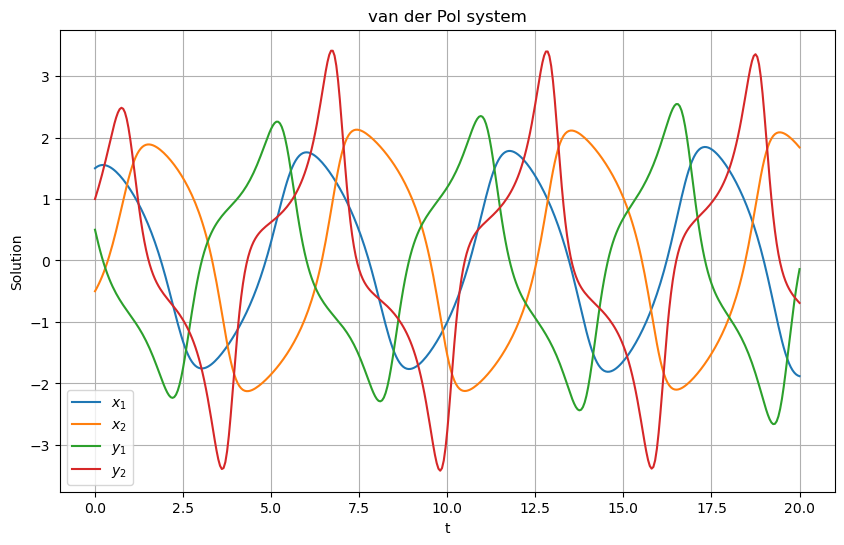

In [25]:
# Plot the solution (Time series plot)
plt.figure(figsize=(10, 6))
plt.plot(t_points, sol[0], label=f"$x_1$")
plt.plot(t_points, sol[2], label=f"$x_2$")
plt.plot(t_points, sol[1], label=f"$y_1$")
plt.plot(t_points, sol[3], label=f"$y_2$")
plt.grid()
plt.xlabel("t")
plt.ylabel("Solution")
plt.legend()
plt.title("van der Pol system")

Text(0.5, 1.0, 'Oscillator 2')

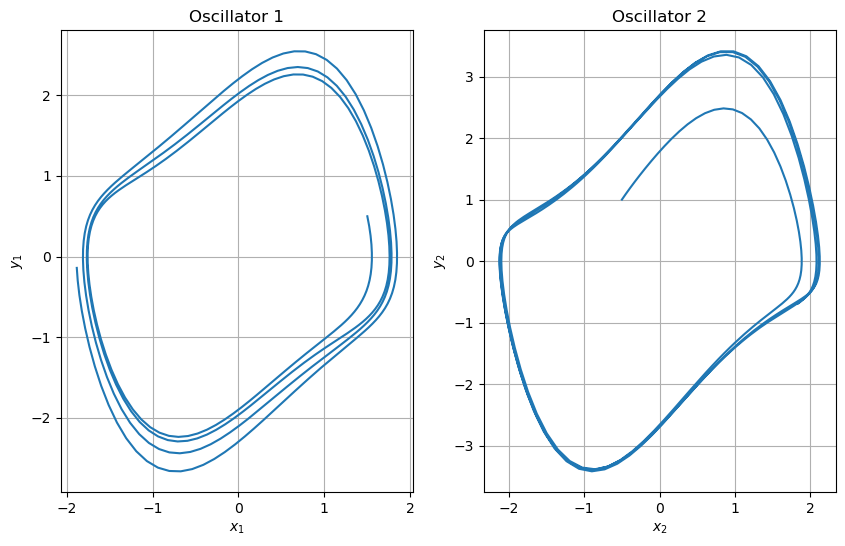

In [26]:
# Plot the solution (Phase space plot)
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(sol[0], sol[1])
plt.grid()
plt.xlabel(f"$x_1$")
plt.ylabel(f"$y_1$")
plt.title("Oscillator 1")

plt.subplot(122)
plt.plot(sol[2], sol[3])
plt.grid()
plt.xlabel(f"$x_2$")
plt.ylabel(f"$y_2$")
plt.title("Oscillator 2")

## Data Generation


In [48]:
def generate_data(n):
    dt = 0.05
    t0, tfinal = 0, 20
    times, initials, targets = [], [], []

    for _ in range(n):
        x1, x2 = np.random.uniform(-2.5, 2.5, size=2)
        y1, y2 = np.random.uniform(-4.0, 4.0, size=2)
        z0 = [x1, y1, x2, y2]

        t_points = np.arange(t0, tfinal + dt, dt)
        sol = solve_ivp(
            vdp_system, [t0, tfinal], z0, t_eval=t_points, args=params, rtol=1e-6
        ).y.T

        for i, t in enumerate(t_points):
            times.append(t)
            initials.append(z0)
            targets.append(sol[i])

    times = np.array(times).reshape(-1, 1)
    initials = np.array(initials)
    targets = np.array(targets)

    return times, initials, targets

In [49]:
n_train = 1000
n_test = 100

train_times, train_initial, train_targets = generate_data(n_train)
test_times, test_initial, test_targets = generate_data(n_test)

X_train = np.concatenate([train_initial, train_times], axis=1)
X_test = np.concatenate([test_initial, test_times], axis=1)

## Model Architecture


In [43]:
inp = tf.keras.layers.Input(shape=(5,))  # x1, y1, x2, y2, time
x = tf.keras.layers.Dense(256, activation="relu")(inp)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
out = tf.keras.layers.Dense(4)(x)  # x1, y1, x2, y2

model = tf.keras.Model(inp, out)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,900 (175.39 KB)

 Trainable params: 44,900 (175.39 KB)

 Non-trainable params: 0 (0.00 B)

## Training


In [44]:
history = model.fit(
    X_train,
    train_targets,
    validation_data=(X_test, test_targets),
    epochs=50,
    batch_size=1024,
    verbose=1,
)

# Report final test loss
test_loss = model.evaluate(X_test, test_targets, verbose=0)
print(f"Final test loss: {test_loss}")

Epoch 1/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.0044 - mae: 1.1971 - val_loss: 1.4658 - val_mae: 0.9645
Epoch 2/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3662 - mae: 0.9157 - val_loss: 1.1384 - val_mae: 0.8072
Epoch 3/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0860 - mae: 0.7855 - val_loss: 0.9332 - val_mae: 0.7239
Epoch 4/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9025 - mae: 0.7035 - val_loss: 0.7665 - val_mae: 0.6512
Epoch 5/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7457 - mae: 0.6325 - val_loss: 0.6460 - val_mae: 0.5872
Epoch 6/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6265 - mae: 0.5717 - val_loss: 0.5385 - val_mae: 0.5247
Epoch 7/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5377 - mae: 0.5276 - val_loss: 0.4940 - val_mae: 0.5194
Epoch 8/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4751 - mae: 0.4969 - val_loss: 0.4293 - val_mae: 0.4703
Epoch 9/50
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

## Testing


In [57]:
# test params
z0_test = np.array([1.0, 0.5, -0.5, 1.0])

In [58]:
test_sol = solve_ivp(
    vdp_system, [t0, tfinal], z0_test, t_eval=t_points, args=params, rtol=1e-6
).y.T

In [68]:
np.tile(z0_test, (len(t_points), 1))

array([[ 1. ,  0.5, -0.5,  1. ],
       [ 1. ,  0.5, -0.5,  1. ],
       [ 1. ,  0.5, -0.5,  1. ],
       ...,
       [ 1. ,  0.5, -0.5,  1. ],
       [ 1. ,  0.5, -0.5,  1. ],
       [ 1. ,  0.5, -0.5,  1. ]])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


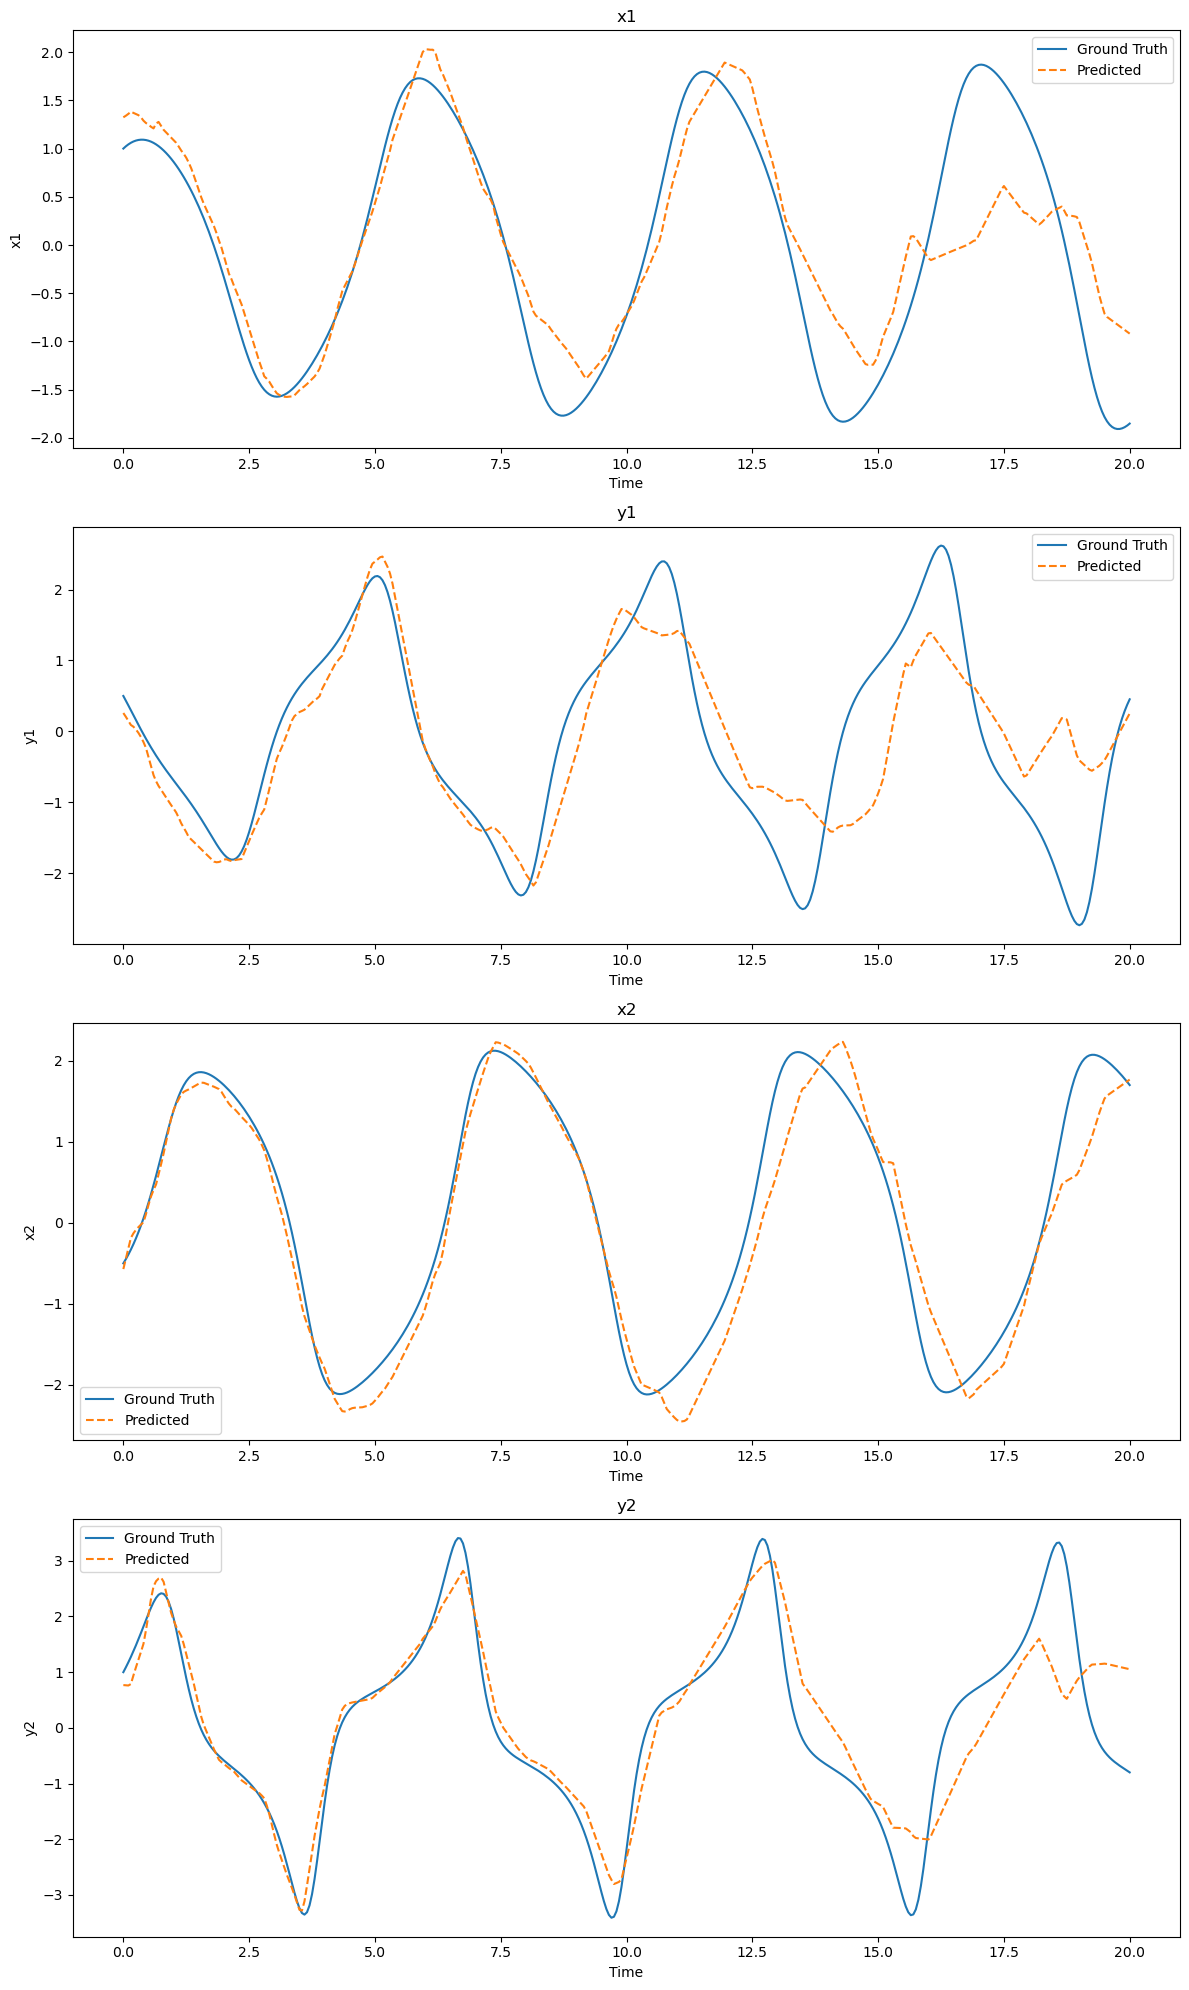

In [71]:
# Prepare data for prediction
times = t_points.reshape(-1, 1)
pred_initial = np.tile(z0_test, (len(t_points), 1))
X_pred = np.concatenate([pred_initial, times], axis=1)

# Make predictions
pred_sol = model.predict(X_pred)

# Plot the results
plt.figure(figsize=(12, 20))
components = ["x1", "y1", "x2", "y2"]

for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.plot(t_points, test_sol[:, i], "-", label="Ground Truth")
    plt.plot(t_points, pred_sol[:, i], "--", label="Predicted")
    plt.xlabel("Time")
    plt.ylabel(components[i])
    plt.title(f"{components[i]}")
    plt.legend()

plt.tight_layout()

In [60]:
# Calculate and print mean squared error for the test case
mse = np.mean((test_sol - predicted_sol) ** 2, axis=0)
print(f"MSE per component: {mse}")
print(f"Overall MSE: {np.mean(mse)}")

MSE per component: [0.36808556 0.69875314 0.16916355 0.51323687]
Overall MSE: 0.43730977982728814
